In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  5 02:25:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   32C    P0    28W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model_1 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_1.trainable = False
    
    # Create the base model from the pre-trained model
  base_model_2 = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_2.trainable = False  

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  x = tf.keras.layers.Rescaling(scale=1./255)(x)
  x = tfio.experimental.color.rgb_to_xyz(x)
  print("Using the converted colors")

#     x = tf.keras.applications.densenet.preprocess_input(x)
#     print("Using preprocessing")

  x1 = base_model_1(x)
  x1 = tf.keras.layers.MaxPooling2D()(x1)
  x1 = tf.keras.layers.Dropout(0.2)(x1)
  x1 = tf.keras.layers.Flatten()(x1)
    
  x2 = base_model_2(x)  
  x2 = tf.keras.layers.MaxPooling2D()(x2)
  x2 = tf.keras.layers.Dropout(0.2)(x2)
  x2 = tf.keras.layers.Flatten()(x2)
    
  concatted = tf.keras.layers.Concatenate()([x1, x2])

  concatted = tf.keras.layers.Dense(512, activation='relu')(concatted)
  concatted = tf.keras.layers.Dropout(0.2)(concatted)
  concatted = tf.keras.layers.Dense(128, activation='relu')(concatted)
  outputs = tf.keras.layers.Dense(5)(concatted)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 69s 129ms/step - loss: 0.5524 - accuracy: 0.7753 - val_loss: 0.3769 - val_accuracy: 0.8475
Epoch 2/100
360/360 [==============================] - 38s 104ms/step - loss: 0.3960 - accuracy: 0.8372 - val_loss: 0.3142 - val_accuracy: 0.8737
Epoch 3/100
360/360 [==============================] - 36s 101ms/step - loss: 0.3735 - accuracy: 0.8468 - val_loss: 0.3634 - val_accuracy: 0.8487
Epoch 4/100
360/360 [==============================] - 39s 109ms/step - loss: 0.3550 - accuracy: 0.8531 - val_loss: 0.3134 - val_accuracy: 0.8767
Epoch 5/100
360/360 [==============================] - 35s 98ms/step - loss: 0.3374 - accuracy: 0.8633 - val_loss: 0.3031 - val_accuracy: 0.8876
Epoch 6/100
360/360 [==============================] - 36s 100ms/step - loss: 0.3322 - accuracy

Epoch 56/100
360/360 [==============================] - 36s 100ms/step - loss: 0.2217 - accuracy: 0.9112 - val_loss: 0.2209 - val_accuracy: 0.9199
Epoch 57/100
360/360 [==============================] - 35s 98ms/step - loss: 0.2269 - accuracy: 0.9115 - val_loss: 0.2262 - val_accuracy: 0.9184
Epoch 58/100
360/360 [==============================] - 36s 100ms/step - loss: 0.2254 - accuracy: 0.9104 - val_loss: 0.2189 - val_accuracy: 0.9196
Epoch 59/100
360/360 [==============================] - 35s 98ms/step - loss: 0.2209 - accuracy: 0.9130 - val_loss: 0.2261 - val_accuracy: 0.9198
Epoch 60/100
360/360 [==============================] - 36s 100ms/step - loss: 0.2238 - accuracy: 0.9100 - val_loss: 0.2244 - val_accuracy: 0.9161
Epoch 61/100
360/360 [==============================] - 36s 99ms/step - loss: 0.2264 - accuracy: 0.9097 - val_loss: 0.2327 - val_accuracy: 0.9121
Epoch 62/100
360/360 [==============================] - 36s 101ms/step - loss: 0.2191 - accuracy: 0.9146 - val_loss: 0.21

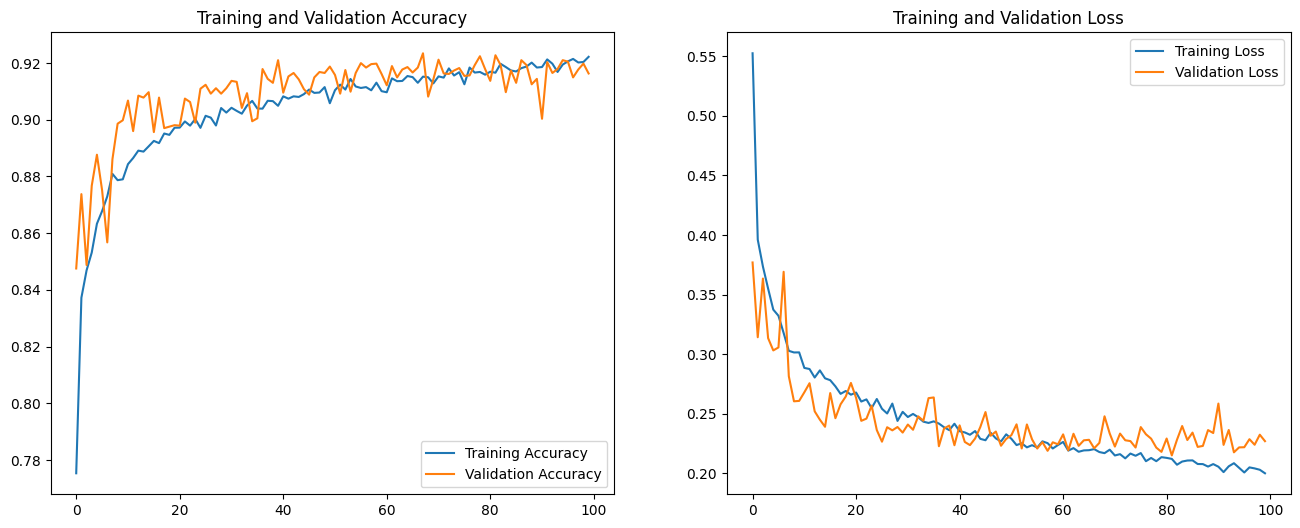

In [4]:
# DenseNet169 XYZ* + DenseNet201 XYZ*
conf1 = train_model()

In [5]:
np.max(conf1['val_acc'])

0.9234108924865723

In [11]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model_1 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_1.trainable = False
    
    # Create the base model from the pre-trained model
  base_model_2 = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_2.trainable = False  

      
    # Create the base model from the pre-trained model
  base_model_3 = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_3.trainable = False    
    
  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  x = tf.keras.layers.Rescaling(scale=1./255)(x)
  x = tfio.experimental.color.rgb_to_xyz(x)
  print("Using the converted colors")

#     x = tf.keras.applications.densenet.preprocess_input(x)
#     print("Using preprocessing")

  x1 = base_model_1(x)
  x1 = tf.keras.layers.MaxPooling2D()(x1)
  x1 = tf.keras.layers.Dropout(0.2)(x1)
  x1 = tf.keras.layers.Flatten()(x1)
    
  x2 = base_model_2(x)  
  x2 = tf.keras.layers.MaxPooling2D()(x2)
  x2 = tf.keras.layers.Dropout(0.2)(x2)
  x2 = tf.keras.layers.Flatten()(x2)
    
  x3 = base_model_3(x)  
  x3 = tf.keras.layers.MaxPooling2D()(x3)
  x3 = tf.keras.layers.Dropout(0.2)(x3)
  x3 = tf.keras.layers.Flatten()(x3)    
    
  concatted = tf.keras.layers.Concatenate()([x1, x2, x3])

  concatted = tf.keras.layers.Dense(512, activation='relu')(concatted)
  concatted = tf.keras.layers.Dropout(0.2)(concatted)
  concatted = tf.keras.layers.Dense(128, activation='relu')(concatted)
  outputs = tf.keras.layers.Dense(5)(concatted)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 79s 155ms/step - loss: 0.5868 - accuracy: 0.7781 - val_loss: 0.3738 - val_accuracy: 0.8512
Epoch 2/100
360/360 [==============================] - 49s 135ms/step - loss: 0.3943 - accuracy: 0.8373 - val_loss: 0.3272 - val_accuracy: 0.8635
Epoch 3/100
360/360 [==============================] - 47s 132ms/step - loss: 0.3651 - accuracy: 0.8526 - val_loss: 0.3323 - val_accuracy: 0.8654
Epoch 4/100
360/360 [==============================] - 49s 135ms/step - loss: 0.3544 - accuracy: 0.8557 - val_loss: 0.3467 - val_accuracy: 0.8512
Epoch 5/100
360/360 [==============================] - 48s 133ms/step - loss: 0.3405 - accuracy: 0.8628 - val_loss: 0.2893 - val_accuracy: 0.8885
Epoch 6/100
360/360 [==============================] - 48s 132ms/step - loss: 0.3202 - accurac

360/360 [==============================] - 47s 132ms/step - loss: 0.2117 - accuracy: 0.9160 - val_loss: 0.2197 - val_accuracy: 0.9166
Epoch 56/100
360/360 [==============================] - 48s 133ms/step - loss: 0.2133 - accuracy: 0.9178 - val_loss: 0.2198 - val_accuracy: 0.9192
Epoch 57/100
360/360 [==============================] - 48s 133ms/step - loss: 0.2143 - accuracy: 0.9161 - val_loss: 0.2180 - val_accuracy: 0.9208
Epoch 58/100
360/360 [==============================] - 47s 132ms/step - loss: 0.2146 - accuracy: 0.9152 - val_loss: 0.2245 - val_accuracy: 0.9146
Epoch 59/100
360/360 [==============================] - 47s 131ms/step - loss: 0.2100 - accuracy: 0.9193 - val_loss: 0.2112 - val_accuracy: 0.9215
Epoch 60/100
360/360 [==============================] - 47s 131ms/step - loss: 0.2133 - accuracy: 0.9166 - val_loss: 0.2129 - val_accuracy: 0.9187
Epoch 61/100
360/360 [==============================] - 47s 131ms/step - loss: 0.2121 - accuracy: 0.9171 - val_loss: 0.2108 - val_a

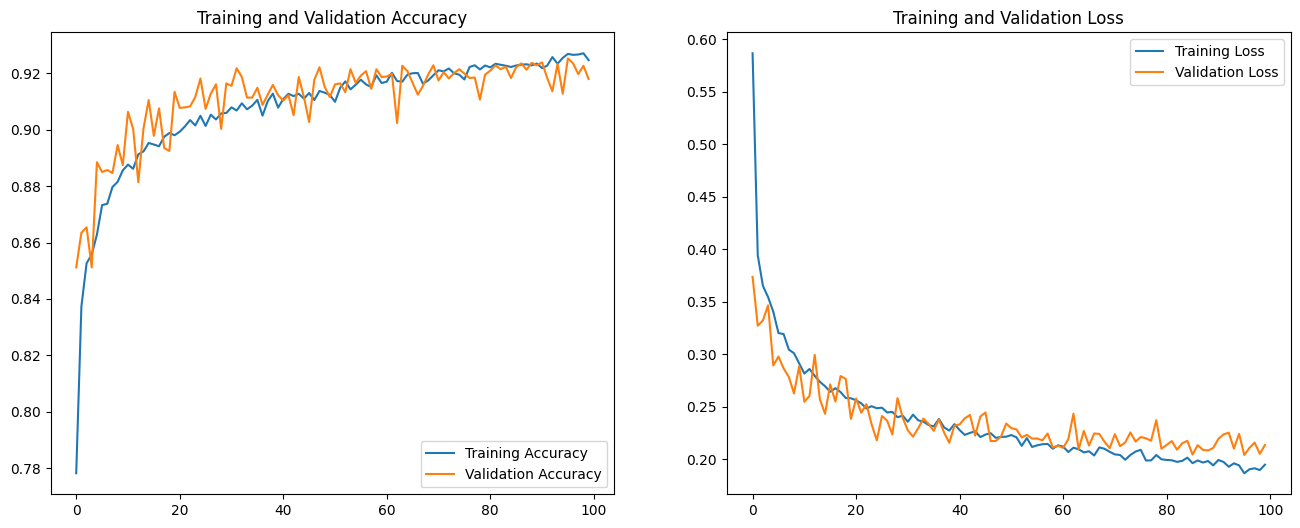

In [12]:
# DenseNet169 XYZ* + DenseNet201 XYZ* + DenseNet121 XYZ*
conf2 = train_model()

In [17]:
np.max(conf2['val_acc'])

0.9253212809562683

In [13]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model_1 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_1.trainable = False
    
    # Create the base model from the pre-trained model
  base_model_2 = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_2.trainable = False  

      
    # Create the base model from the pre-trained model
  base_model_3 = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_3.trainable = False    
    
  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  x = tf.keras.layers.Rescaling(scale=1./255)(x)
  x = tfio.experimental.color.rgb_to_xyz(x)
  print("Using the converted colors")

#     x = tf.keras.applications.densenet.preprocess_input(x)
#     print("Using preprocessing")

  x1 = base_model_1(x)
  x1 = tf.keras.layers.MaxPooling2D()(x1)
  x1 = tf.keras.layers.Dropout(0.2)(x1)
  x1 = tf.keras.layers.Flatten()(x1)
    
  x2 = base_model_2(x)  
  x2 = tf.keras.layers.MaxPooling2D()(x2)
  x2 = tf.keras.layers.Dropout(0.2)(x2)
  x2 = tf.keras.layers.Flatten()(x2)
    
  x3 = base_model_3(x)  
  x3 = tf.keras.layers.MaxPooling2D()(x3)
  x3 = tf.keras.layers.Dropout(0.2)(x3)
  x3 = tf.keras.layers.Flatten()(x3)    
    
  concatted = tf.keras.layers.Concatenate()([x1, x2, x3])

  concatted = tf.keras.layers.Dense(512, activation='relu')(concatted)
  concatted = tf.keras.layers.Dropout(0.2)(concatted)
  concatted = tf.keras.layers.Dense(128, activation='relu')(concatted)
  outputs = tf.keras.layers.Dense(5)(concatted)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 77s 151ms/step - loss: 0.5011 - accuracy: 0.8001 - val_loss: 0.3347 - val_accuracy: 0.8765
Epoch 2/100
360/360 [==============================] - 47s 131ms/step - loss: 0.3679 - accuracy: 0.8497 - val_loss: 0.3403 - val_accuracy: 0.8626
Epoch 3/100
360/360 [==============================] - 47s 130ms/step - loss: 0.3406 - accuracy: 0.8629 - val_loss: 0.3289 - val_accuracy: 0.8713
Epoch 4/100
360/360 [==============================] - 47s 131ms/step - loss: 0.3260 - accuracy: 0.8702 - val_loss: 0.3038 - val_accuracy: 0.8859
Epoch 5/100
360/360 [==============================] - 47s 130ms/step - loss: 0.3127 - accuracy: 0.8744 - val_loss: 0.2995 - val_accuracy: 0.8869
Epoch 6/100
360/360 [==============================] - 47s 129ms/step - loss: 0.2998 - accurac

360/360 [==============================] - 46s 128ms/step - loss: 0.1885 - accuracy: 0.9260 - val_loss: 0.2105 - val_accuracy: 0.9251
Epoch 56/100
360/360 [==============================] - 46s 129ms/step - loss: 0.1906 - accuracy: 0.9275 - val_loss: 0.2234 - val_accuracy: 0.9158
Epoch 57/100
360/360 [==============================] - 46s 128ms/step - loss: 0.1872 - accuracy: 0.9252 - val_loss: 0.2175 - val_accuracy: 0.9212
Epoch 58/100
360/360 [==============================] - 46s 128ms/step - loss: 0.1843 - accuracy: 0.9292 - val_loss: 0.2183 - val_accuracy: 0.9227
Epoch 59/100
360/360 [==============================] - 47s 130ms/step - loss: 0.1854 - accuracy: 0.9277 - val_loss: 0.2454 - val_accuracy: 0.9140
Epoch 60/100
360/360 [==============================] - 46s 129ms/step - loss: 0.1912 - accuracy: 0.9263 - val_loss: 0.2260 - val_accuracy: 0.9149
Epoch 61/100
360/360 [==============================] - 46s 128ms/step - loss: 0.1863 - accuracy: 0.9282 - val_loss: 0.2240 - val_a

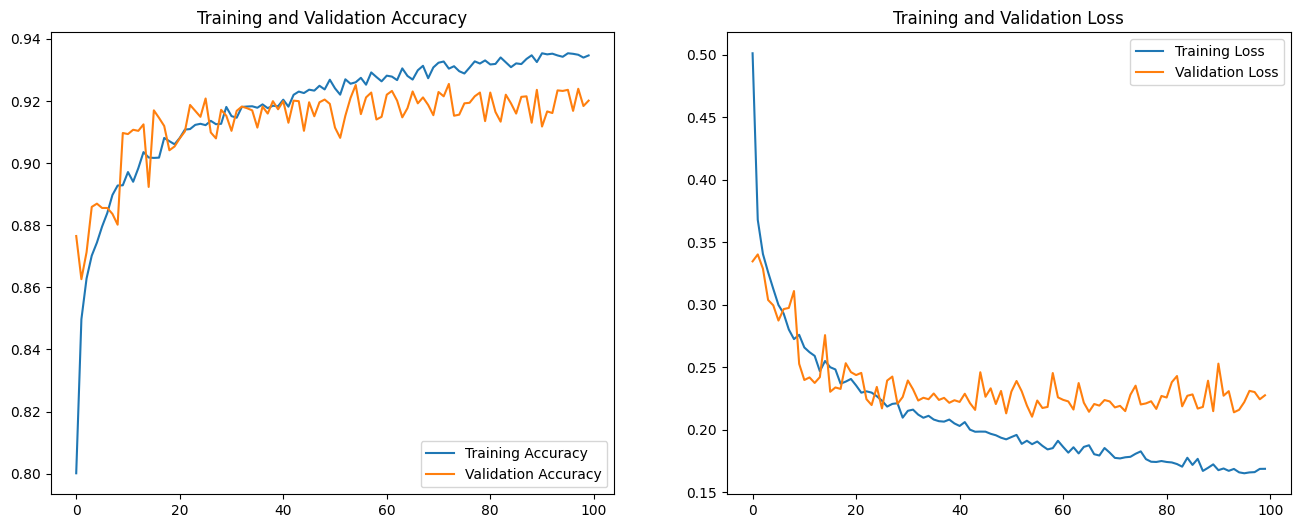

In [14]:
# DenseNet169 XYZ* + DenseNet201 XYZ* + Xception XYZ*
conf3 = train_model()

In [16]:
np.max(conf3['val_acc'])

0.9254949688911438

In [ ]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model_1 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_1.trainable = False
    
    # Create the base model from the pre-trained model
  base_model_2 = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_2.trainable = False  

      
    # Create the base model from the pre-trained model
  base_model_3 = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_3.trainable = False    
    
    
    
    # Create the base model from the pre-trained model
  base_model_4 = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_4.trainable = False  
    
  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  x = tf.keras.layers.Rescaling(scale=1./255)(x)
  x = tfio.experimental.color.rgb_to_xyz(x)
  print("Using the converted colors")

#     x = tf.keras.applications.densenet.preprocess_input(x)
#     print("Using preprocessing")

  x1 = base_model_1(x)
  x1 = tf.keras.layers.MaxPooling2D()(x1)
  x1 = tf.keras.layers.Dropout(0.2)(x1)
  x1 = tf.keras.layers.Flatten()(x1)
    
  x2 = base_model_2(x)  
  x2 = tf.keras.layers.MaxPooling2D()(x2)
  x2 = tf.keras.layers.Dropout(0.2)(x2)
  x2 = tf.keras.layers.Flatten()(x2)
    
  x3 = base_model_3(x)  
  x3 = tf.keras.layers.MaxPooling2D()(x3)
  x3 = tf.keras.layers.Dropout(0.2)(x3)
  x3 = tf.keras.layers.Flatten()(x3)    
    
  x4 = base_model_4(x)  
  x4 = tf.keras.layers.MaxPooling2D()(x4)
  x4 = tf.keras.layers.Dropout(0.2)(x4)
  x4 = tf.keras.layers.Flatten()(x4)  
    
  concatted = tf.keras.layers.Concatenate()([x1, x2, x3, x4])

  concatted = tf.keras.layers.Dense(512, activation='relu')(concatted)
  concatted = tf.keras.layers.Dropout(0.2)(concatted)
  concatted = tf.keras.layers.Dense(128, activation='relu')(concatted)
  outputs = tf.keras.layers.Dense(5)(concatted)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

In [ ]:
conf = train_model()